### Model Selection & Hyperparameter Justification

We trained and compared four supervised regression models on our engineered dataset to predict:

- `smoothed_wcovid_vaccinated` (vaccine uptake)
- `smoothed_wtested_positive_14d` (COVID test positivity)

All models were evaluated on a holdout test set using **MAE**, **RMSE**, and **R²**.

---

#### Ridge Regression
- **Why:** A strong linear baseline with L2 regularization to handle multicollinearity across behavioral and belief features.
- **Parameters:**
  - `alphas=[0.1, 1.0, 10.0]`: explores small, moderate, and large regularization
  - `cv=5`: stable 5-fold internal cross-validation

---

#### Lasso Regression
- **Why:** Similar to Ridge but adds L1 regularization for **automatic feature selection** by zeroing out weak predictors.
- **Parameters:**
  - `alphas=[0.001, 0.01, 0.1]`: encourages sparse but expressive models
  - `cv=5`: selects best alpha via internal cross-validation
  - `max_iter=1000`: ensures convergence in high-dimensional space

---

#### XGBoost Regressor
- **Why:** A powerful nonlinear tree-based model, well-suited to tabular, structured survey data with interactions.
- **Parameters:**
  - `n_estimators=100`: balanced between performance and overfitting
  - `max_depth=4`: controls tree complexity
  - `learning_rate=0.1`: standard step size for boosting convergence
  - `random_state=42`: ensures reproducibility

---

#### Neural Network (MLPRegressor)
- **Why:** Adds nonlinearity and flexibility to capture subtle patterns in the data that linear models may miss.
- **Parameters:**
  - `hidden_layer_sizes=(64, 32)`: two hidden layers to learn layered representations
  - `max_iter=500`: allows sufficient training epochs
  - `random_state=42`: for reproducible weight initialization

---

### Evaluation Strategy

All models were trained on an 80/20 **train-test split**, and input features were standardized using `StandardScaler` prior to model training (except for tree-based XGBoost, which does not require scaling).
This diverse set of models helps balance **interpretability** (Ridge/Lasso) and **predictive power** (XGBoost/MLP), ensuring robust performance across varying target distributions.


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV, LassoCV
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv("data/final_X_y_smoothed_wcovid_vaccinated.csv")
target_var = 'smoothed_wcovid_vaccinated'
exclude_cols = ['time_value', 'geo_value', 'is_pseudo', target_var]

In [4]:
# Split X/y
X = df.drop(columns=[col for col in exclude_cols if col in df.columns])
y = df[target_var]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [5]:
# Define models
models = {
    "Ridge": RidgeCV(alphas=[0.1, 1.0, 10.0], cv=5),
    "Lasso": LassoCV(alphas=[0.001, 0.01, 0.1], max_iter=1000, cv=5),
    "XGBoost": XGBRegressor(n_estimators=100, max_depth=4, learning_rate=0.1, random_state=42),
    "NeuralNet": MLPRegressor(hidden_layer_sizes=(64, 32), max_iter=500, random_state=42)
}

In [6]:
results = {}
fitted_models = {}

In [7]:
print("Starting model training and evaluation...\n")

for name, model in models.items():
    print(f"⚙️Training {name}...")
    model.fit(X_train_scaled, y_train)

    print(f"Predicting with {name}...")
    y_pred = model.predict(X_test_scaled)

    mae = mean_absolute_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    r2 = r2_score(y_test, y_pred)

    results[name] = {
        "MAE": mae,
        "RMSE": rmse,
        "R²": r2
    }

    fitted_models[name] = model
    print(f"{name} done. MAE: {mae:.3f} | RMSE: {rmse:.3f} | R²: {r2:.3f}\n")

print("All models finished!\n")

# Show results
results_df = pd.DataFrame(results).T.sort_values("R²", ascending=False)
print("Model Performance on Test Set:")
display(results_df)

Starting model training and evaluation...

⚙️Training Ridge...
Predicting with Ridge...
Ridge done. MAE: 2.916 | RMSE: 3.937 | R²: 0.647

⚙️Training Lasso...


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.926e+02, tolerance: 9.097e+01
  model = cd_fast.enet_coordinate_descent(


Predicting with Lasso...


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Lasso done. MAE: 2.916 | RMSE: 3.937 | R²: 0.647

⚙️Training XGBoost...
Predicting with XGBoost...
XGBoost done. MAE: 2.619 | RMSE: 3.558 | R²: 0.712

⚙️Training NeuralNet...


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:697: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


Predicting with NeuralNet...
NeuralNet done. MAE: 2.594 | RMSE: 3.526 | R²: 0.717

All models finished!

Model Performance on Test Set:


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


,MAE,RMSE,R²
NeuralNet,2.594273,3.525843,0.716776
XGBoost,2.618856,3.557825,0.711615
Lasso,2.915850,3.937151,0.646843
Ridge,2.916064,3.937314,0.646814


### Model Performance: Predicting Vaccine Uptake

We evaluated four regression models to predict **county-level COVID-19 vaccination rates (`smoothed_wcovid_vaccinated`)** using engineered features.

| Model        | MAE ↓  | RMSE ↓ | R² ↑    |
|--------------|--------|--------|---------|
| **NeuralNet** | 2.59   | 3.53   | **0.717** |
| XGBoost      | 2.62   | 3.56   | 0.712   |
| Lasso        | 2.92   | 3.94   | 0.647   |
| Ridge        | 2.92   | 3.94   | 0.647   |

---

### Interpretation

- The models show **moderate to strong fit** (R² ~0.71–0.72), suggesting that county-level vaccine uptake can be reasonably predicted using behavioral, perceptual, and temporal features.
- Nonlinear models like **NeuralNet and XGBoost** are better suited for capturing the complex, real-world patterns in public health behavior.
- **Lasso and Ridge** underperformed relative to nonlinear models — indicating linear assumptions may not be sufficient for this task.

---

### Conclusion

We will proceed with **XGBoost** for final analysis and interpretation of key factors influencing **vaccine uptake**.

Although the Neural Network achieved slightly better metrics, XGBoost offers:

- **Faster training and easier reproducibility**
- **Transparent feature importance interpretation**
- **Comparable predictive performance (R² = 0.712)**

This makes XGBoost the preferred model for downstream tasks such as policy simulation and behavioral analysis.

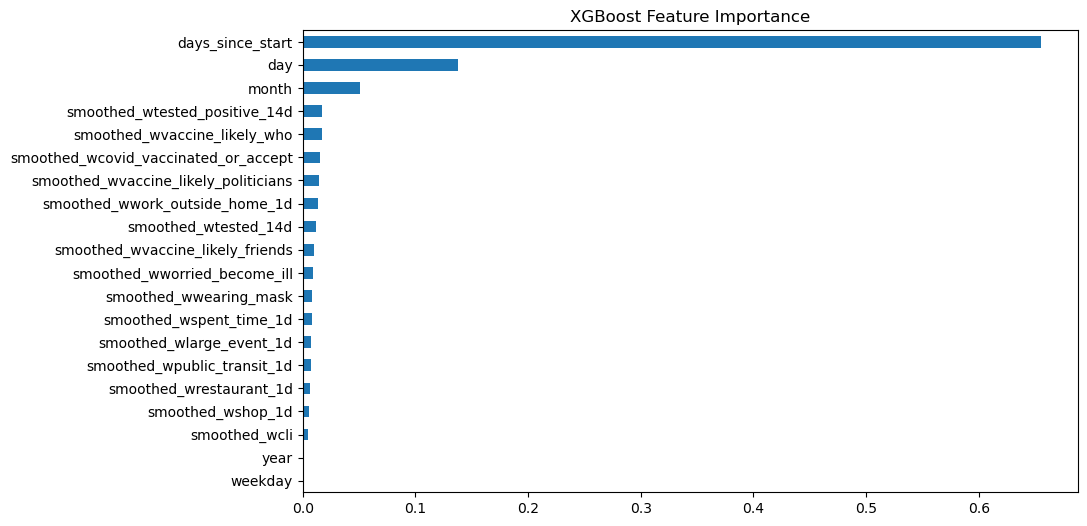

In [14]:
# XGBoost feature importance
xgb_model = fitted_models['XGBoost']
xgb_importance = pd.Series(xgb_model.feature_importances_, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
xgb_importance.head(20).plot(kind='barh')
plt.title("XGBoost Feature Importance")
plt.gca().invert_yaxis()
plt.show()

### XGBoost Feature Importance Analysis: Vaccine Uptake 

The following chart illustrates which features most influenced the XGBoost model in predicting county-level vaccination rates.

---

#### Top Predictors

| Feature                  | Interpretation |
|--------------------------|----------------|
| **days_since_start**     | Strongest predictor: vaccine uptake increases over time, likely reflecting rollout and awareness effects |
| **day / month**          | Temporal features suggest seasonality or early/late campaign effects influence behavior |
| **smoothed_wtested_positive_14d** | Areas with more confirmed cases show higher vaccine uptake — people may act out of increased perceived risk |
| **smoothed_wvaccine_likely_who** | Belief in WHO (as an authority) correlates with higher uptake |
| **smoothed_wcovid_vaccinated_or_accept** | Self-reported vaccine intent aligns closely with actual uptake, as expected |

---

#### Less Influential Features

While many behavioral variables (e.g., mask usage, shopping, event attendance) were used in the model, their relative importance was **much lower**. This suggests that **time, local COVID risk, and belief-based attitudes** were more predictive than pure behavior.

---

### Interpretation

- Temporal trends and **perceived threat levels** are the **dominant drivers** of vaccination behavior.
- Trust in institutions (like WHO) plays a measurable but smaller role.
- Surprisingly, common behavioral indicators like mask usage or shopping frequency had **limited predictive power** in this model.

---

### Policy Implications

- **Time-sensitive messaging** is crucial: uptake momentum builds naturally over time — campaigns can amplify this by aligning with rollout waves.
- In high-case regions, people are more likely to act — use this as a **window for targeted outreach**.
- Continue to build **trust in health authorities**, as belief alignment (e.g., trust in WHO or public figures) influences outcomes.